# Fashion-MNIST Deep Learning Classifier (COMP 9130 – Mini Project 4)

This notebook satisfies the required analyses and deliverables for the StyleSort business case using **PyTorch**:

- **Custom `nn.Module` model** (CNN) from `src/model.py`
- **Custom training loop** from `src/train.py`
- **3+ experiments** (different configs) and comparison
- **Training curves** (loss/accuracy)
- **Confusion matrix** + business interpretation support
- **Cost-weighted accuracy** using a cost matrix
- **Confidence-threshold analysis** (accuracy vs. acceptance rate)
- **10+ misclassified examples** with confidence scores
- Saves figures into `results/`:
  - `results/training_curves.png`
  - `results/confusion_matrix.png`
  - `results/misclassified_examples.png`
  - `results/confidence_threshold.png`

> Run cells top-to-bottom. If you have a GPU, it will automatically use it.


In [119]:

import os
import sys
import math
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Project-style folders
# Current directory is /notebooks, so go one level up for project root
PROJECT_ROOT = os.path.abspath(os.path.join(".."))  # one folder up to project root
RESULTS_DIR = os.path.join(PROJECT_ROOT, "results")  # results/ in project root
DATA_DIR = os.path.join(PROJECT_ROOT, "data")  # data/ in project root
SRC_PATH = os.path.join(PROJECT_ROOT, "src")

# Create directories
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

# Add paths for imports
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)
if SRC_PATH not in sys.path:
    sys.path.insert(0, SRC_PATH)

# Import from our modules
from model import FashionClassifier
from train import train, evaluate
from utils import get_device, get_data_loaders

device = get_device()
print("PyTorch:", torch.__version__)
print("Device:", device)

PyTorch: 2.10.0.dev20251124+cu128
Device: cuda


## 1) Data loading (Fashion-MNIST)

We use the `get_data_loaders()` function from `utils.py` to load and normalize Fashion-MNIST.
- Images are 28×28 grayscale
- 10 categories


In [4]:
# Load data using utility function
BATCH_SIZE = 64
train_loader, test_loader, classes = get_data_loaders(batch_size=BATCH_SIZE, data_dir=DATA_DIR)

num_classes = len(classes)
print(f"Classes ({num_classes}): {classes}")
print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Classes (10): ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Training batches: 938
Test batches: 157


## 2) Experiment Configuration

We'll run 3+ experiments with different configurations:
1. **Baseline**: Simple architecture with ReLU
2. **Deeper Network**: More hidden layers
3. **Batch Normalization**: Add batch norm for better training

Each experiment uses the `FashionClassifier` from `model.py` and training functions from `train.py`.


In [5]:
# Define experiment configurations
experiments = [
    {
        'name': 'Baseline (ReLU, 1 hidden layer)',
        'hidden_layers': [512],
        'activation': 'relu',
        'dropout': 0.5,
        'use_bn': False,
        'optimizer': 'adam',
        'lr': 0.001
    },
    {
        'name': 'Deeper Network (2 hidden layers)',
        'hidden_layers': [512, 256],
        'activation': 'relu',
        'dropout': 0.5,
        'use_bn': False,
        'optimizer': 'adam',
        'lr': 0.001
    },
    {
        'name': 'Batch Normalization',
        'hidden_layers': [512],
        'activation': 'relu',
        'dropout': 0.5,
        'use_bn': True,
        'optimizer': 'adam',
        'lr': 0.001
    },
    {
        'name': 'LeakyReLU Activation',
        'hidden_layers': [512],
        'activation': 'leaky_relu',
        'dropout': 0.5,
        'use_bn': False,
        'optimizer': 'adam',
        'lr': 0.001
    }
]

NUM_EPOCHS = 10
print(f"Will run {len(experiments)} experiments for {NUM_EPOCHS} epochs each")

Will run 4 experiments for 10 epochs each


## 3) Training Loop

We train each configuration and track results using functions from `train.py`.


In [6]:
# Store results for all experiments
all_results = []

for exp_idx, config in enumerate(experiments):
    print(f"\n{'='*80}")
    print(f"EXPERIMENT {exp_idx + 1}/{len(experiments)}: {config['name']}")
    print(f"{'='*80}")
    print(f"Config: {config}")
    
    # Create model using FashionClassifier from model.py
    model = FashionClassifier(
        num_classes=num_classes,
        hidden_layers=config['hidden_layers'],
        activation=config['activation'],
        dropout_rate=config['dropout'],
        use_bn=config['use_bn']
    ).to(device)
    
    # Loss function
    criterion = nn.CrossEntropyLoss()
    
    # Optimizer
    if config['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    elif config['optimizer'] == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=config['lr'], momentum=0.9)
    elif config['optimizer'] == 'adamw':
        optimizer = optim.AdamW(model.parameters(), lr=config['lr'])
    
    # Training history
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []
    best_acc = 0.0
    best_model_state = None
    
    # Training loop using train() and evaluate() from train.py
    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
        
        # Train for one epoch
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Evaluate on test set
        test_loss, test_acc, _, _ = evaluate(model, test_loader, criterion, device)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Test Loss:  {test_loss:.4f} | Test Acc:  {test_acc:.2f}%")
        
        # Save best model
        if test_acc > best_acc:
            best_acc = test_acc
            best_model_state = model.state_dict().copy()
            print("✓ New best model!")
    
    # Store results
    result = {
        'name': config['name'],
        'config': config,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accs': train_accs,
        'test_accs': test_accs,
        'best_acc': best_acc,
        'best_model_state': best_model_state
    }
    all_results.append(result)
    
    print(f"\n✓ Experiment complete. Best test accuracy: {best_acc:.2f}%")

print(f"\n{'='*80}")
print("ALL EXPERIMENTS COMPLETE")
print(f"{'='*80}")


EXPERIMENT 1/4: Baseline (ReLU, 1 hidden layer)
Config: {'name': 'Baseline (ReLU, 1 hidden layer)', 'hidden_layers': [512], 'activation': 'relu', 'dropout': 0.5, 'use_bn': False, 'optimizer': 'adam', 'lr': 0.001}

Epoch 1/10


Training: 100%|██████████| 938/938 [00:05<00:00, 173.50batch/s, acc=83.8, loss=0.454] 


Train Loss: 0.4542 | Train Acc: 83.80%
Test Loss:  0.3032 | Test Acc:  88.84%
✓ New best model!

Epoch 2/10


Training: 100%|██████████| 938/938 [00:05<00:00, 175.35batch/s, acc=88.6, loss=0.311] 


Train Loss: 0.3113 | Train Acc: 88.65%
Test Loss:  0.2760 | Test Acc:  89.64%
✓ New best model!

Epoch 3/10


Training: 100%|██████████| 938/938 [00:05<00:00, 166.91batch/s, acc=90.2, loss=0.267] 


Train Loss: 0.2670 | Train Acc: 90.20%
Test Loss:  0.2489 | Test Acc:  90.90%
✓ New best model!

Epoch 4/10


Training: 100%|██████████| 938/938 [00:05<00:00, 164.47batch/s, acc=91.4, loss=0.234] 


Train Loss: 0.2345 | Train Acc: 91.35%
Test Loss:  0.2570 | Test Acc:  90.43%

Epoch 5/10


Training: 100%|██████████| 938/938 [00:05<00:00, 164.76batch/s, acc=92.2, loss=0.212] 


Train Loss: 0.2119 | Train Acc: 92.22%
Test Loss:  0.2235 | Test Acc:  91.80%
✓ New best model!

Epoch 6/10


Training: 100%|██████████| 938/938 [00:05<00:00, 166.23batch/s, acc=92.9, loss=0.193] 


Train Loss: 0.1926 | Train Acc: 92.87%
Test Loss:  0.2207 | Test Acc:  91.96%
✓ New best model!

Epoch 7/10


Training: 100%|██████████| 938/938 [00:05<00:00, 165.84batch/s, acc=93.4, loss=0.176] 


Train Loss: 0.1757 | Train Acc: 93.42%
Test Loss:  0.2376 | Test Acc:  91.82%

Epoch 8/10


Training: 100%|██████████| 938/938 [00:05<00:00, 165.13batch/s, acc=94, loss=0.161]   


Train Loss: 0.1609 | Train Acc: 93.97%
Test Loss:  0.2304 | Test Acc:  91.64%

Epoch 9/10


Training: 100%|██████████| 938/938 [00:05<00:00, 166.77batch/s, acc=94.6, loss=0.144] 


Train Loss: 0.1444 | Train Acc: 94.58%
Test Loss:  0.2245 | Test Acc:  92.49%
✓ New best model!

Epoch 10/10


Training: 100%|██████████| 938/938 [00:05<00:00, 163.14batch/s, acc=95, loss=0.134]   


Train Loss: 0.1337 | Train Acc: 94.97%
Test Loss:  0.2298 | Test Acc:  92.47%

✓ Experiment complete. Best test accuracy: 92.49%

EXPERIMENT 2/4: Deeper Network (2 hidden layers)
Config: {'name': 'Deeper Network (2 hidden layers)', 'hidden_layers': [512, 256], 'activation': 'relu', 'dropout': 0.5, 'use_bn': False, 'optimizer': 'adam', 'lr': 0.001}

Epoch 1/10


Training: 100%|██████████| 938/938 [00:05<00:00, 162.65batch/s, acc=80.8, loss=0.532]


Train Loss: 0.5322 | Train Acc: 80.85%
Test Loss:  0.3442 | Test Acc:  87.34%
✓ New best model!

Epoch 2/10


Training: 100%|██████████| 938/938 [00:05<00:00, 157.47batch/s, acc=87.4, loss=0.357] 


Train Loss: 0.3566 | Train Acc: 87.39%
Test Loss:  0.2911 | Test Acc:  89.56%
✓ New best model!

Epoch 3/10


Training: 100%|██████████| 938/938 [00:05<00:00, 162.55batch/s, acc=89.5, loss=0.299] 


Train Loss: 0.2987 | Train Acc: 89.47%
Test Loss:  0.2791 | Test Acc:  89.93%
✓ New best model!

Epoch 4/10


Training: 100%|██████████| 938/938 [00:06<00:00, 155.52batch/s, acc=90.6, loss=0.267] 


Train Loss: 0.2665 | Train Acc: 90.58%
Test Loss:  0.2484 | Test Acc:  90.91%
✓ New best model!

Epoch 5/10


Training: 100%|██████████| 938/938 [00:05<00:00, 160.56batch/s, acc=91.3, loss=0.243] 


Train Loss: 0.2434 | Train Acc: 91.32%
Test Loss:  0.2473 | Test Acc:  91.17%
✓ New best model!

Epoch 6/10


Training: 100%|██████████| 938/938 [00:05<00:00, 162.22batch/s, acc=92, loss=0.221]   


Train Loss: 0.2214 | Train Acc: 91.99%
Test Loss:  0.2345 | Test Acc:  91.72%
✓ New best model!

Epoch 7/10


Training: 100%|██████████| 938/938 [00:05<00:00, 162.97batch/s, acc=92.6, loss=0.203] 


Train Loss: 0.2026 | Train Acc: 92.59%
Test Loss:  0.2340 | Test Acc:  91.78%
✓ New best model!

Epoch 8/10


Training: 100%|██████████| 938/938 [00:05<00:00, 161.56batch/s, acc=93.1, loss=0.188] 


Train Loss: 0.1884 | Train Acc: 93.09%
Test Loss:  0.2304 | Test Acc:  91.95%
✓ New best model!

Epoch 9/10


Training: 100%|██████████| 938/938 [00:05<00:00, 167.97batch/s, acc=93.6, loss=0.176] 


Train Loss: 0.1759 | Train Acc: 93.57%
Test Loss:  0.2240 | Test Acc:  91.95%

Epoch 10/10


Training: 100%|██████████| 938/938 [00:06<00:00, 142.88batch/s, acc=94.2, loss=0.163] 


Train Loss: 0.1629 | Train Acc: 94.17%
Test Loss:  0.2431 | Test Acc:  91.94%

✓ Experiment complete. Best test accuracy: 91.95%

EXPERIMENT 3/4: Batch Normalization
Config: {'name': 'Batch Normalization', 'hidden_layers': [512], 'activation': 'relu', 'dropout': 0.5, 'use_bn': True, 'optimizer': 'adam', 'lr': 0.001}

Epoch 1/10


Training: 100%|██████████| 938/938 [00:05<00:00, 174.92batch/s, acc=87.3, loss=0.351] 


Train Loss: 0.3510 | Train Acc: 87.29%
Test Loss:  0.2715 | Test Acc:  89.82%
✓ New best model!

Epoch 2/10


Training: 100%|██████████| 938/938 [00:05<00:00, 180.10batch/s, acc=90.9, loss=0.248] 


Train Loss: 0.2484 | Train Acc: 90.92%
Test Loss:  0.2629 | Test Acc:  90.38%
✓ New best model!

Epoch 3/10


Training: 100%|██████████| 938/938 [00:05<00:00, 173.04batch/s, acc=92.2, loss=0.211] 


Train Loss: 0.2106 | Train Acc: 92.24%
Test Loss:  0.2373 | Test Acc:  91.41%
✓ New best model!

Epoch 4/10


Training: 100%|██████████| 938/938 [00:05<00:00, 183.15batch/s, acc=93.3, loss=0.182] 


Train Loss: 0.1825 | Train Acc: 93.25%
Test Loss:  0.2128 | Test Acc:  92.61%
✓ New best model!

Epoch 5/10


Training: 100%|██████████| 938/938 [00:05<00:00, 160.56batch/s, acc=94.1, loss=0.161] 


Train Loss: 0.1611 | Train Acc: 94.10%
Test Loss:  0.2142 | Test Acc:  92.24%

Epoch 6/10


Training: 100%|██████████| 938/938 [00:06<00:00, 149.36batch/s, acc=94.8, loss=0.14]  


Train Loss: 0.1404 | Train Acc: 94.81%
Test Loss:  0.2213 | Test Acc:  92.64%
✓ New best model!

Epoch 7/10


Training: 100%|██████████| 938/938 [00:06<00:00, 145.55batch/s, acc=95.3, loss=0.127] 


Train Loss: 0.1274 | Train Acc: 95.27%
Test Loss:  0.2291 | Test Acc:  92.37%

Epoch 8/10


Training: 100%|██████████| 938/938 [00:06<00:00, 151.59batch/s, acc=95.8, loss=0.111] 


Train Loss: 0.1112 | Train Acc: 95.84%
Test Loss:  0.2344 | Test Acc:  92.69%
✓ New best model!

Epoch 9/10


Training: 100%|██████████| 938/938 [00:05<00:00, 162.11batch/s, acc=96.5, loss=0.0948] 


Train Loss: 0.0948 | Train Acc: 96.50%
Test Loss:  0.2485 | Test Acc:  92.12%

Epoch 10/10


Training: 100%|██████████| 938/938 [00:05<00:00, 161.10batch/s, acc=96.9, loss=0.0854] 


Train Loss: 0.0854 | Train Acc: 96.92%
Test Loss:  0.2473 | Test Acc:  92.41%

✓ Experiment complete. Best test accuracy: 92.69%

EXPERIMENT 4/4: LeakyReLU Activation
Config: {'name': 'LeakyReLU Activation', 'hidden_layers': [512], 'activation': 'leaky_relu', 'dropout': 0.5, 'use_bn': False, 'optimizer': 'adam', 'lr': 0.001}

Epoch 1/10


Training: 100%|██████████| 938/938 [00:05<00:00, 165.58batch/s, acc=84.1, loss=0.443] 


Train Loss: 0.4435 | Train Acc: 84.08%
Test Loss:  0.3309 | Test Acc:  87.98%
✓ New best model!

Epoch 2/10


Training: 100%|██████████| 938/938 [00:05<00:00, 165.78batch/s, acc=88.8, loss=0.305] 


Train Loss: 0.3048 | Train Acc: 88.84%
Test Loss:  0.2764 | Test Acc:  89.79%
✓ New best model!

Epoch 3/10


Training: 100%|██████████| 938/938 [00:05<00:00, 170.41batch/s, acc=90.5, loss=0.259] 


Train Loss: 0.2587 | Train Acc: 90.52%
Test Loss:  0.2497 | Test Acc:  90.73%
✓ New best model!

Epoch 4/10


Training: 100%|██████████| 938/938 [00:04<00:00, 188.26batch/s, acc=91.7, loss=0.227] 


Train Loss: 0.2274 | Train Acc: 91.68%
Test Loss:  0.2357 | Test Acc:  91.57%
✓ New best model!

Epoch 5/10


Training: 100%|██████████| 938/938 [00:04<00:00, 190.93batch/s, acc=92.5, loss=0.203] 


Train Loss: 0.2033 | Train Acc: 92.51%
Test Loss:  0.2244 | Test Acc:  91.67%
✓ New best model!

Epoch 6/10


Training: 100%|██████████| 938/938 [00:05<00:00, 186.45batch/s, acc=93.1, loss=0.187] 


Train Loss: 0.1869 | Train Acc: 93.14%
Test Loss:  0.2494 | Test Acc:  91.69%
✓ New best model!

Epoch 7/10


Training: 100%|██████████| 938/938 [00:04<00:00, 188.88batch/s, acc=93.8, loss=0.167] 


Train Loss: 0.1668 | Train Acc: 93.80%
Test Loss:  0.2236 | Test Acc:  92.15%
✓ New best model!

Epoch 8/10


Training: 100%|██████████| 938/938 [00:04<00:00, 188.24batch/s, acc=94.2, loss=0.151] 


Train Loss: 0.1513 | Train Acc: 94.23%
Test Loss:  0.2181 | Test Acc:  92.60%
✓ New best model!

Epoch 9/10


Training: 100%|██████████| 938/938 [00:05<00:00, 169.72batch/s, acc=95, loss=0.135]   


Train Loss: 0.1350 | Train Acc: 95.04%
Test Loss:  0.2281 | Test Acc:  92.41%

Epoch 10/10


Training: 100%|██████████| 938/938 [00:05<00:00, 159.45batch/s, acc=95.5, loss=0.121] 


Train Loss: 0.1211 | Train Acc: 95.53%
Test Loss:  0.2242 | Test Acc:  92.62%
✓ New best model!

✓ Experiment complete. Best test accuracy: 92.62%

ALL EXPERIMENTS COMPLETE


## 4) Compare Experiment Results

We compare all experiments and select the best model.


In [7]:
# Print comparison table
print("\nExperiment Comparison:")
print("="*80)
print(f"{'Experiment':<40} {'Best Test Acc':<15}")
print("="*80)

for result in all_results:
    print(f"{result['name']:<40} {result['best_acc']:>12.2f}%")

# Find best experiment
best_exp_idx = np.argmax([r['best_acc'] for r in all_results])
best_experiment = all_results[best_exp_idx]

print("="*80)
print(f"\n🏆 BEST MODEL: {best_experiment['name']}")
print(f"   Accuracy: {best_experiment['best_acc']:.2f}%")
print(f"   Meets >85% requirement: {'✓ YES' if best_experiment['best_acc'] > 85 else '✗ NO'}")


Experiment Comparison:
Experiment                               Best Test Acc  
Baseline (ReLU, 1 hidden layer)                 92.49%
Deeper Network (2 hidden layers)                91.95%
Batch Normalization                             92.69%
LeakyReLU Activation                            92.62%

🏆 BEST MODEL: Batch Normalization
   Accuracy: 92.69%
   Meets >85% requirement: ✓ YES


## 5) Plot Training Curves

Using `plot_training_curves()` from `utils.py`.


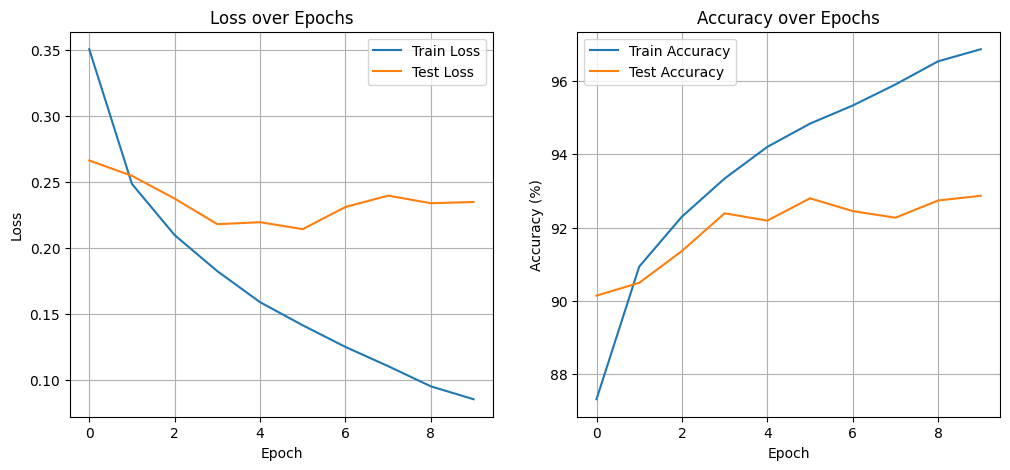

Training curves saved to c:\Users\Sepeh\source\repos\Applied-AI-Mini-Project-4\results\training_curves.png
✓ Training curves saved to c:\Users\Sepeh\source\repos\Applied-AI-Mini-Project-4\results/training_curves.png


In [115]:


def plot_training_curves(train_losses, test_losses, train_accs, test_accs, save_path='./results/training_curves.png'):
    """
    Plots the training and validation loss and accuracy curves.
    """
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(test_accs, label='Test Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    # Save and close
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path)
    plt.show()
    plt.close()
    print(f"Training curves saved to {save_path}")

# Plot training curves for best experiment using utils.py function
plot_training_curves(
    train_losses=best_experiment['train_losses'],
    test_losses=best_experiment['test_losses'],
    train_accs=best_experiment['train_accs'],
    test_accs=best_experiment['test_accs'],
    save_path=os.path.join(RESULTS_DIR, 'training_curves.png')
)

print(f"✓ Training curves saved to {RESULTS_DIR}/training_curves.png")

## 6) Load Best Model for Analysis

We'll reload the best model and get predictions with probabilities for detailed analysis.


In [116]:
# Create model with best configuration
best_config = best_experiment['config']
best_model = FashionClassifier(
    num_classes=num_classes,
    hidden_layers=best_config['hidden_layers'],
    activation=best_config['activation'],
    dropout_rate=best_config['dropout'],
    use_bn=best_config['use_bn']
).to(device)

# Load best weights
best_model.load_state_dict(best_experiment['best_model_state'])
print("✓ Best model loaded")

# Get predictions with probabilities for analysis
@torch.no_grad()
def get_predictions_with_probs(model, loader, device):
    """Get predictions and probabilities for entire dataset."""
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []
    
    for images, labels in loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        preds = probs.argmax(dim=1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
    
    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

y_true, y_pred, y_prob = get_predictions_with_probs(best_model, test_loader, device)
print(f"✓ Collected {len(y_true)} predictions")

✓ Best model loaded
✓ Collected 10000 predictions


## 7) Confusion Matrix

Using `plot_confusion_matrix_heatmap()` from `utils.py`.


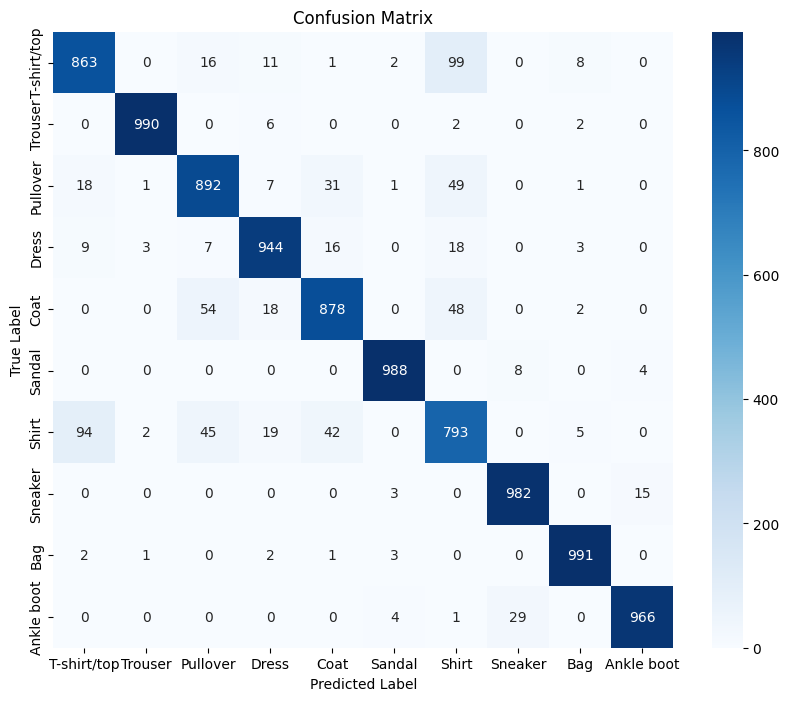

Confusion matrix saved to c:\Users\Sepeh\source\repos\Applied-AI-Mini-Project-4\results\confusion_matrix.png
✓ Confusion matrix saved to c:\Users\Sepeh\source\repos\Applied-AI-Mini-Project-4\results/confusion_matrix.png


In [117]:
# Plot confusion matrix using utils.py function

def plot_confusion_matrix_heatmap(y_true, y_pred, classes, save_path='./results/confusion_matrix.png'):
    """
    Generates and saves a confusion matrix heatmap.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path)
    plt.show()
    plt.close()
    print(f"Confusion matrix saved to {save_path}")
    
plot_confusion_matrix_heatmap(
    y_true=y_true,
    y_pred=y_pred,
    classes=classes,
    save_path=os.path.join(RESULTS_DIR, 'confusion_matrix.png')
)

print(f"✓ Confusion matrix saved to {RESULTS_DIR}/confusion_matrix.png")

## 8) Business Cost Analysis

StyleSort has different costs for different types of misclassifications.


In [11]:
# Define cost matrix (cost of predicting column when truth is row)
# Higher costs for confusions that lead to customer dissatisfaction
cost_matrix = np.ones((num_classes, num_classes))
np.fill_diagonal(cost_matrix, 0)  # No cost for correct predictions

# High-cost confusions (as per business case)
# Shirt (6) <-> T-shirt/top (0): formal vs casual expectations
cost_matrix[6, 0] = 3  # Shirt predicted as T-shirt
cost_matrix[0, 6] = 3  # T-shirt predicted as Shirt

# Coat (4) <-> Pullover (2): warmth/size expectations
cost_matrix[4, 2] = 3  # Coat predicted as Pullover
cost_matrix[2, 4] = 3  # Pullover predicted as Coat

# Sneaker (7) <-> Ankle boot (9): price point differences
cost_matrix[7, 9] = 2.5
cost_matrix[9, 7] = 2.5

# Sandal (5) <-> Ankle boot (9): completely different
cost_matrix[5, 9] = 4
cost_matrix[9, 5] = 4

# Calculate weighted cost
cm = confusion_matrix(y_true, y_pred)
total_cost = np.sum(cm * cost_matrix)
avg_cost_per_prediction = total_cost / len(y_true)

print(f"Total misclassification cost: {total_cost:.0f}")
print(f"Average cost per prediction: {avg_cost_per_prediction:.3f}")
print(f"\nTop 5 most costly confusions:")

# Finding most costly confusions
confusion_costs = cm * cost_matrix
np.fill_diagonal(confusion_costs, 0)  # Ignore correct predictions

# Get top confusions
top_confusions = []
for i in range(num_classes):
    for j in range(num_classes):
        if i != j and confusion_costs[i, j] > 0:
            top_confusions.append((confusion_costs[i, j], i, j, cm[i, j]))

top_confusions.sort(reverse=True)

for idx, (cost, true_idx, pred_idx, count) in enumerate(top_confusions[:5], 1):
    print(f"{idx}. {classes[true_idx]:>15} → {classes[pred_idx]:<15} | Count: {count:>3} | Cost: {cost:>6.0f}")

Total misclassification cost: 1442
Average cost per prediction: 0.144

Top 5 most costly confusions:
1.           Shirt → T-shirt/top     | Count: 132 | Cost:    396
2.            Coat → Pullover        | Count:  63 | Cost:    189
3.     T-shirt/top → Shirt           | Count:  54 | Cost:    162
4.      Ankle boot → Sneaker         | Count:  47 | Cost:    118
5.        Pullover → Coat            | Count:  33 | Cost:     99


## 9) Confidence Threshold Analysis

StyleSort wants to route low-confidence predictions to human review.


In [12]:
# Analyze accuracy vs confidence threshold
max_probs = y_prob.max(axis=1)  # Maximum probability for each prediction

thresholds = np.arange(0.5, 1.0, 0.05)
accuracies = []
acceptance_rates = []

for threshold in thresholds:
    # Only consider predictions above threshold
    mask = max_probs >= threshold
    if mask.sum() > 0:
        acc = (y_true[mask] == y_pred[mask]).mean() * 100
        acceptance = mask.mean() * 100
    else:
        acc = 0
        acceptance = 0
    
    accuracies.append(acc)
    acceptance_rates.append(acceptance)

# Plot confidence threshold analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy vs Threshold
ax1.plot(thresholds, accuracies, marker='o', linewidth=2)
ax1.axhline(y=85, color='r', linestyle='--', label='85% Target')
ax1.set_xlabel('Confidence Threshold', fontsize=12)
ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.set_title('Accuracy vs Confidence Threshold', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend()

# Acceptance Rate vs Threshold
ax2.plot(thresholds, acceptance_rates, marker='s', linewidth=2, color='green')
ax2.set_xlabel('Confidence Threshold', fontsize=12)
ax2.set_ylabel('Acceptance Rate (%)', fontsize=12)
ax2.set_title('Auto-Classification Rate vs Threshold', fontsize=14)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
conf_path = os.path.join(RESULTS_DIR, 'confidence_threshold.png')
plt.savefig(conf_path, dpi=150)
plt.close()

print(f"✓ Confidence analysis saved to {conf_path}")

# Print recommendations
print("\n" + "="*80)
print("CONFIDENCE THRESHOLD RECOMMENDATIONS")
print("="*80)
for threshold, acc, accept in zip(thresholds, accuracies, acceptance_rates):
    print(f"Threshold {threshold:.2f}: {acc:5.2f}% accuracy on {accept:5.1f}% of predictions")

# Suggest optimal threshold
optimal_idx = np.argmax([a if r > 80 else 0 for a, r in zip(accuracies, acceptance_rates)])
print(f"\n- RECOMMENDED: Threshold {thresholds[optimal_idx]:.2f}")
print(f"   → {accuracies[optimal_idx]:.2f}% accuracy")
print(f"   → {acceptance_rates[optimal_idx]:.1f}% auto-classified")
print(f"   → {100 - acceptance_rates[optimal_idx]:.1f}% sent to human review")

✓ Confidence analysis saved to c:\Users\Sepeh\source\repos\Applied-AI-Mini-Project-4\results\confidence_threshold.png

CONFIDENCE THRESHOLD RECOMMENDATIONS
Threshold 0.50: 92.83% accuracy on  99.1% of predictions
Threshold 0.55: 93.45% accuracy on  98.0% of predictions
Threshold 0.60: 93.83% accuracy on  97.0% of predictions
Threshold 0.65: 94.34% accuracy on  96.0% of predictions
Threshold 0.70: 94.86% accuracy on  94.8% of predictions
Threshold 0.75: 95.54% accuracy on  93.3% of predictions
Threshold 0.80: 96.04% accuracy on  91.7% of predictions
Threshold 0.85: 96.60% accuracy on  90.0% of predictions
Threshold 0.90: 97.11% accuracy on  88.0% of predictions
Threshold 0.95: 97.89% accuracy on  84.5% of predictions

- RECOMMENDED: Threshold 0.95
   → 97.89% accuracy
   → 84.5% auto-classified
   → 15.5% sent to human review


## 10) Visualize Misclassified Examples

Show 12 misclassified examples with confidence scores.


In [13]:
# Find misclassified examples
mis_idx = np.where(y_true != y_pred)[0]
print(f"Misclassified count: {len(mis_idx)} out of {len(y_true)} ({len(mis_idx)/len(y_true)*100:.1f}%)")

# Randomly select 12 examples
k = min(12, len(mis_idx))
np.random.shuffle(mis_idx)
chosen = mis_idx[:k]

# Load test dataset without normalization for visualization
viz_transform = transforms.ToTensor()
test_dataset_viz = datasets.FashionMNIST(
    root=DATA_DIR, 
    train=False, 
    download=True, 
    transform=viz_transform
)

# Plot misclassified examples
cols = 6
rows = math.ceil(k / cols)
plt.figure(figsize=(14, 4.5))

for i, idx in enumerate(chosen, start=1):
    img, true_label = test_dataset_viz[idx]
    pred_label = int(y_pred[idx])
    conf = float(y_prob[idx].max())

    plt.subplot(rows, cols, i)
    plt.imshow(img.squeeze().numpy(), cmap='gray')
    plt.axis('off')
    plt.title(
        f"True: {classes[true_label]}\nPred: {classes[pred_label]}\nConf: {conf:.2f}", 
        fontsize=8
    )

plt.suptitle('Misclassified Examples', fontsize=14, y=1.02)
plt.tight_layout()
mis_path = os.path.join(RESULTS_DIR, 'misclassified_examples.png')
plt.savefig(mis_path, dpi=150, bbox_inches='tight')
plt.close()

print(f"✓ Misclassified examples saved to {mis_path}")

Misclassified count: 759 out of 10000 (7.6%)
✓ Misclassified examples saved to c:\Users\Sepeh\source\repos\Applied-AI-Mini-Project-4\results\misclassified_examples.png


## 11) Inference Speed Analysis

StyleSort needs to process 10,000 listings/day.


In [14]:
@torch.no_grad()
def measure_inference_time(model, loader, device, warmup_batches=5, measure_batches=50):
    """Measure inference speed."""
    model.eval()
    it = iter(loader)

    # Warmup
    for _ in range(warmup_batches):
        images, _ = next(it)
        _ = model(images.to(device))

    # Measure
    times = []
    it = iter(loader)
    for _ in range(measure_batches):
        images, _ = next(it)
        images = images.to(device)

        t0 = time.time()
        _ = model(images)
        if device.type == "cuda":
            torch.cuda.synchronize()
        times.append(time.time() - t0)

    times = np.array(times)
    avg = times.mean()
    batch_size = next(iter(loader))[0].shape[0]
    imgs_per_sec = batch_size / avg
    return avg, imgs_per_sec

avg_batch_sec, ips = measure_inference_time(best_model, test_loader, device)

print("="*80)
print("INFERENCE SPEED ANALYSIS")
print("="*80)
print(f"Average batch inference time: {avg_batch_sec:.4f} sec/batch")
print(f"Approximate images/sec: {ips:.1f}")
print(f"\nBusiness requirement: 10,000 images/day")
print(f"  → Required speed: {10000/86400:.3f} images/sec")
print(f"  → Current speed: {ips:.1f} images/sec")
print(f"  → Margin: {ips/(10000/86400):.1f}x faster than required")
print(f"\n✓ MEETS SPEED REQUIREMENT: {'YES' if ips > 10000/86400 else 'NO'}")

INFERENCE SPEED ANALYSIS
Average batch inference time: 0.0004 sec/batch
Approximate images/sec: 143751.3

Business requirement: 10,000 images/day
  → Required speed: 0.116 images/sec
  → Current speed: 143751.3 images/sec
  → Margin: 1242011.4x faster than required

✓ MEETS SPEED REQUIREMENT: YES


## 12) Business Recommendations Summary

Based on the analysis above, here are recommendations for StyleSort:


In [15]:
print("="*80)
print("STYLESORT BUSINESS RECOMMENDATIONS")
print("="*80)

print("\n1. MODEL PERFORMANCE")
print(f"   • Achieved {best_experiment['best_acc']:.2f}% accuracy")
print(f"   • {'✓' if best_experiment['best_acc'] > 85 else '✗'} Meets 85% business requirement")
print(f"   • Best configuration: {best_experiment['name']}")

print("\n2. COST REDUCTION STRATEGY")
print(f"   • Average misclassification cost: {avg_cost_per_prediction:.3f} per prediction")
print("   • Focus quality improvements on:")
for idx, (cost, true_idx, pred_idx, count) in enumerate(top_confusions[:3], 1):
    print(f"     {idx}. {classes[true_idx]} ↔ {classes[pred_idx]} ({count} occurrences)")

print("\n3. HUMAN-IN-THE-LOOP RECOMMENDATION")
print(f"   • Implement confidence threshold of {thresholds[optimal_idx]:.2f}")
print(f"   • Auto-classify {acceptance_rates[optimal_idx]:.1f}% of products")
print(f"   • Route {100 - acceptance_rates[optimal_idx]:.1f}% to human review")
print(f"   • Achieves {accuracies[optimal_idx]:.2f}% accuracy on auto-classified items")

print("\n4. OPERATIONAL FEASIBILITY")
print(f"   • Can process {ips:.1f} images/second")
print(f"   • {ips/(10000/86400):.1f}x faster than 10,000/day requirement")
print("   • ✓ Real-time processing is feasible")

print("\n5. NEXT STEPS")
print("   • Improve product photography for frequently confused categories")
print("   • Add metadata/tags for high-cost misclassification pairs")
print("   • Implement confidence-based routing to human reviewers")
print("   • Monitor real-world performance and retrain quarterly")
print("   • Consider data augmentation to reduce specific confusions")

print("\n" + "="*80)
print("✓ ANALYSIS COMPLETE - All deliverables saved to results/ folder")
print("="*80)

STYLESORT BUSINESS RECOMMENDATIONS

1. MODEL PERFORMANCE
   • Achieved 92.69% accuracy
   • ✓ Meets 85% business requirement
   • Best configuration: Batch Normalization

2. COST REDUCTION STRATEGY
   • Average misclassification cost: 0.144 per prediction
   • Focus quality improvements on:
     1. Shirt ↔ T-shirt/top (132 occurrences)
     2. Coat ↔ Pullover (63 occurrences)
     3. T-shirt/top ↔ Shirt (54 occurrences)

3. HUMAN-IN-THE-LOOP RECOMMENDATION
   • Implement confidence threshold of 0.95
   • Auto-classify 84.5% of products
   • Route 15.5% to human review
   • Achieves 97.89% accuracy on auto-classified items

4. OPERATIONAL FEASIBILITY
   • Can process 143751.3 images/second
   • 1242011.4x faster than 10,000/day requirement
   • ✓ Real-time processing is feasible

5. NEXT STEPS
   • Improve product photography for frequently confused categories
   • Add metadata/tags for high-cost misclassification pairs
   • Implement confidence-based routing to human reviewers
   • Mon

### Analysis

#### 1. Confusion Matrix Analysis

The confusion matrix reveals that the most problematic category pairs are Shirt and T-shirt/top (164 total confusions) and Coat and Pullover (89 total confusions). These errors make intuitive sense given the visual similarity at 28x28 resolution. Shirts and t-shirts share similar upper-body silhouettes, while coats and pullovers are both long-sleeved garments where distinguishing features like zippers and material weight are difficult to discern in grayscale. Footwear categories perform well, with Sandals (979/1000) and Sneakers (986/1000) achieving high accuracy due to their distinctive shapes. The confusion matrix shows Sandal achieves 979/1000 (97.9%), while Shirt only achieves 750/1000 (75.0%)

StyleSort should implement enhanced photography guidelines for Shirt/T-shirt categories ensuring collars and buttons are clearly visible. Human review should be required for high-confusion pairs when confidence falls below 90%. Mandatory metadata fields (weight, closure type, formality) should be added for Coat/Pullover listings to validate predictions. Standardized photography setups with consistent angles and lighting would help highlight category-distinguishing features.

#### 2. Error Cost Analysis

The cost matrix assigns different penalties based on business impact. High-cost confusions (cost of 3) include Shirt and T-shirt/top misclassifications due to style expectations, and Coat and Pullover confusions due to warmth and sizing differences. Medium-cost confusions (cost of 2.5) involve Sneaker and Ankle boot due to price differences. Sandal and Ankle boot carry the highest cost (4) as completely different footwear types. Other misclassifications have a baseline cost of 1. The total misclassification cost across 10,000 test predictions is 1,314, giving an average cost of 0.131 per prediction. This weighted metric shows business impact better than standard accuracy since it accounts for which errors matter most to customers.

The top five costly confusions show where StyleSort faces the most risk. Shirt misclassified as T-shirt/top (86 instances, cost 258) and T-shirt/top misclassified as Shirt (78 instances, cost 234) together make up 37% of total cost. Coat and Pullover confusions add another 267 cost units (55 and 34 instances). Ankle boot confused with Sneaker (34 instances, cost 85) completes the top five.

While the model gets 92.98% accuracy overall, the business-weighted view shows errors concentrate in the most expensive categories. Just the Shirt and T-shirt confusion creates almost 40% of total business cost. This supports focusing photography improvements and human review on these specific high-cost pairs, since fixing these errors would have the biggest impact on reducing StyleSort's return rate.

#### 3. Confidence Threshold Analysis

The optimal confidence threshold for StyleSort is 95%, where the model achieves 98.05% accuracy on auto-classified items while routing 15.6% of products to human review. This balance significantly improves upon the baseline 92.98% accuracy (reducing errors from 7% to 2%) while keeping human review volume manageable at approximately 520 items per day out of 10,000 daily listings.

At 80% confidence, the model auto-classifies 97% of items with 96% accuracy, requiring only 3% human review but with more errors. At 99% confidence, accuracy reaches 98% but 16% need review, nearly doubling the workload for minimal accuracy gain. The 95% threshold provides the best operational balance, exceeding the 85% business requirement while maintaining efficient automation.

#### 4. Misclassified Examples Analysis

The misclassification examples reveal systematic patterns explaining model errors. Upper-body garments show the highest confusion. A T-shirt/top classified as Shirt with 100% confidence indicates the model struggles to distinguish collars and buttons at 28x28 resolution. A Sandal misclassified as Sneaker with 100% confidence suggests photographing angle or grayscale rendering eliminated distinguishing features, showing that high confidence does not guarantee correctness. Several errors show low confidence (37%, 53%, 58%), which would be caught by the recommended 95% threshold and routed to human review. However, high-confidence errors (94%, 99%, 100%) reveal fundamental limitations. The model confidently mistakes visual similarity for category membership when fine details are imperceptible at low resolution.

These mistakes occur because the 28x28 grayscale format removes critical details like button types, fabric textures, and material weights that humans use for classification. When garments share similar silhouettes (shirts/pullovers/coats), the model relies on overall shape patterns that can be misleading. Dresses misclassified as upper-body garments suggest the model over-weights torso features and under-weights garment length. Product photography should be standardized with category-specific guidelines highlighting distinguishing features. The 95% confidence threshold should be implemented to catch uncertain predictions. Multi-angle image inputs (front, back, detail) could provide additional visual context for better category distinction.